# OpenStreetMap (OSM) Road Network Data - Loading and Exploration

**Objective**: Load and explore OpenStreetMap road network data for the regions where accidents occurred, to enable spatial joining of accidents with road segments.

**Data Source**: OpenStreetMap via OSMnx library
- Road network topology (nodes and edges)
- Road attributes (type, lanes, speed limit, surface, etc.)
- Geographic coverage matching accident dataset

## Notebook Contents
1. Environment Setup
2. Identify Geographic Regions from Accidents
3. Download OSM Road Networks
4. Road Network Statistics
5. Road Type Distribution
6. Road Attributes Analysis
7. Data Quality Assessment
8. Save Processed Road Networks

## 1. Environment Setup

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from shapely.geometry import Point, LineString, box
import warnings
warnings.filterwarnings('ignore')

print("✓ Required packages imported")
print(f"OSMnx version: {ox.__version__}")
print(f"GeoPandas version: {gpd.__version__}")

✓ Required packages imported
OSMnx version: 2.0.6
GeoPandas version: 1.1.1


In [23]:
# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from src.config import Config
from src.utils.logging import setup_logger

# Setup
logger = setup_logger(__name__)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = True

print("✓ Environment setup complete")
print(f"Project root: {project_root}")

✓ Environment setup complete
Project root: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project


## 2. Load Accident Data for Geographic Reference

We'll load the preprocessed accident data to identify the geographic regions we need road networks for.

In [24]:
# Load preprocessed accident data (sample for faster processing)
accidents_path = Config.ACCIDENTS_CLEANED_DIR / "US_Accidents_preProcessed_sample.csv"

print(f"Loading accident data from: {accidents_path}")
df_accidents = pd.read_csv(accidents_path, parse_dates=['Start_Time', 'End_Time'])

print(f"\n✓ Loaded {len(df_accidents):,} accident records")
print(f"Geographic coverage: {df_accidents['State'].nunique()} states, {df_accidents['City'].nunique():,} cities")

Loading accident data from: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/US_Accidents_preProcessed_sample.csv

✓ Loaded 77,284 accident records
Geographic coverage: 49 states, 5,926 cities

✓ Loaded 77,284 accident records
Geographic coverage: 49 states, 5,926 cities


Top 10 States by Accident Count:
CA           17,342 (22.44%)
FL            8,509 (11.01%)
TX            5,919 ( 7.66%)
SC            3,933 ( 5.09%)
NY            3,500 ( 4.53%)
NC            3,375 ( 4.37%)
PA            3,095 ( 4.00%)
VA            2,959 ( 3.83%)
MN            1,917 ( 2.48%)
OR            1,864 ( 2.41%)


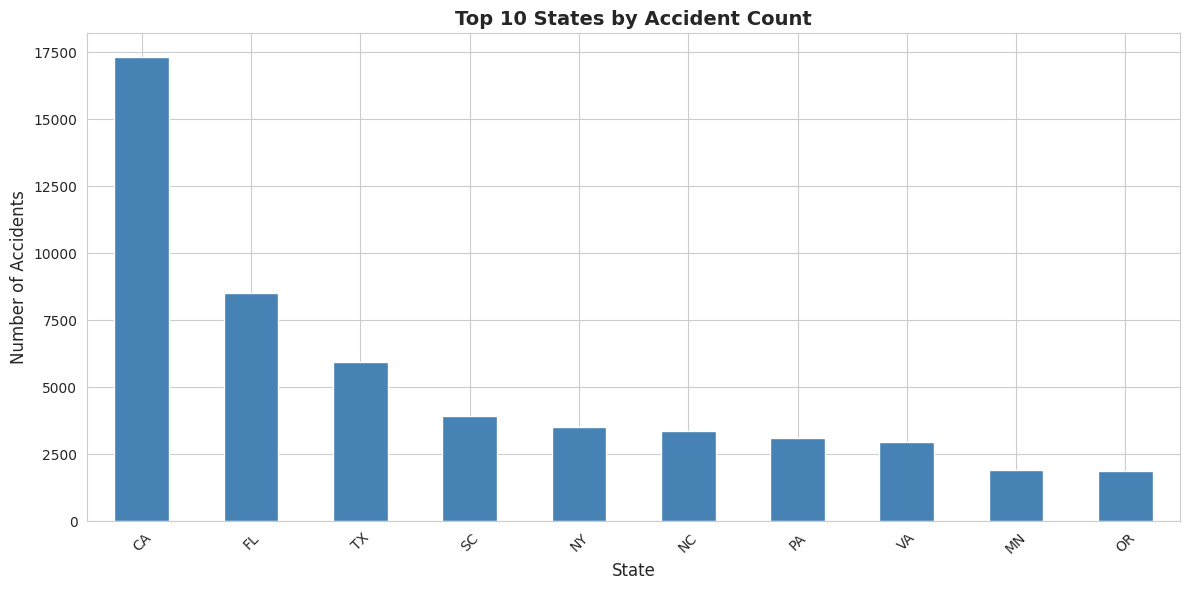

In [25]:
# Analyze geographic distribution
state_counts = df_accidents['State'].value_counts().head(10)

print("Top 10 States by Accident Count:")
print("="*50)
for state, count in state_counts.items():
    pct = (count / len(df_accidents)) * 100
    print(f"{state:10s} {count:>8,} ({pct:5.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
state_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 10 States by Accident Count', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Convert Accidents to GeoDataFrame

Convert the accident points to a GeoPandas GeoDataFrame for spatial operations.

In [26]:
# Create geometry from lat/lng coordinates
geometry = [Point(xy) for xy in zip(df_accidents['Start_Lng'], df_accidents['Start_Lat'])]

# Create GeoDataFrame
gdf_accidents = gpd.GeoDataFrame(
    df_accidents,
    geometry=geometry,
    crs='EPSG:4326'  # WGS84 coordinate system
)

print("✓ GeoDataFrame created")
print(f"CRS: {gdf_accidents.crs}")
display(gdf_accidents.describe)
print(f"Bounds: {gdf_accidents.total_bounds}")
print("\nFirst few records:")
gdf_accidents[['ID', 'State', 'City', 'Start_Lat', 'Start_Lng', 'geometry']].head()

✓ GeoDataFrame created
CRS: EPSG:4326


<bound method NDFrame.describe of               ID   Source  Severity          Start_Time  \
0      A-7182628  Source1         1 2020-04-17 09:29:30   
1      A-5404588  Source1         2 2022-04-21 10:01:00   
2       A-156000  Source3         3 2016-08-12 16:45:00   
3      A-1871277  Source2         3 2019-09-20 15:22:16   
4      A-2031222  Source2         2 2019-06-03 16:55:43   
...          ...      ...       ...                 ...   
77279  A-6111264  Source1         2 2021-10-19 10:40:30   
77280  A-6473693  Source1         2 2021-02-06 03:37:00   
77281  A-6032652  Source1         2 2021-04-16 05:56:00   
77282  A-1476641  Source2         2 2020-05-21 17:56:01   
77283  A-6181263  Source1         2 2021-07-02 14:50:56   

                            End_Time  Start_Lat   Start_Lng    End_Lat  \
0                2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
1                2022-04-21 11:44:08  38.781025 -121.265820  38.780376   
2                2016-08-12 17:15:0

Bounds: [-124.53573    24.60268   -68.22687    48.995777]

First few records:


,ID,State,City,Start_Lat,Start_Lng,geometry
0,A-7182628,FL,West Palm Beach,26.706900,-80.11936,POINT (-80.11936 26.7069)
1,A-5404588,CA,Roseville,38.781025,-121.26582,POINT (-121.26582 38.78102)
2,A-156000,GA,Alpharetta,33.985250,-84.26935,POINT (-84.26935 33.98525)
3,A-1871277,WA,Tacoma,47.118706,-122.55691,POINT (-122.55691 47.11871)
4,A-2031222,AZ,Scottsdale,33.451355,-111.89034,POINT (-111.89034 33.45136)


## 4. Download OSM Road Networks

We'll download road networks for specific cities/regions. For demonstration, we'll start with a few high-accident cities.

In [27]:
# Select top cities for road network download
# Start with a small sample to test the workflow
TOP_CITIES = 3  # Adjust based on computational resources

# Get top cities by accident count
city_state_counts = df_accidents.groupby(['City', 'State']).size().sort_values(ascending=False)
top_cities = city_state_counts.head(TOP_CITIES)

print(f"Downloading road networks for top {TOP_CITIES} cities:")
print("="*60)
for (city, state), count in top_cities.items():
    print(f"{city}, {state}: {count:,} accidents")

Miami, FL: 1,812 accidents
Houston, TX: 1,733 accidents
Los Angeles, CA: 1,551 accidents


In [28]:
%%time
# Download road networks for selected cities
# Note: This may take several minutes depending on city size

road_networks = {}

for (city, state), count in top_cities.items():
    try:
        print(f"\nDownloading road network for {city}, {state}...")
        
        # Download drivable road network
        G = ox.graph_from_place(
            f"{city}, {state}, USA",
            network_type='drive',
            simplify=True
        )
        
        # Convert to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G)
        
        road_networks[f"{city}, {state}"] = {
            'graph': G,
            'nodes': nodes,
            'edges': edges,
            'accident_count': count
        }
        
        print(f"  ✓ Downloaded: {len(nodes):,} nodes, {len(edges):,} edges")
        
    except Exception as e:
        print(f"  ✗ Error downloading {city}, {state}: {str(e)}")
        continue

print(f"\n✓ Successfully downloaded {len(road_networks)} road networks")


  ✓ Downloaded: 9,084 nodes, 23,555 edges

  ✓ Downloaded: 9,084 nodes, 23,555 edges

  ✓ Downloaded: 59,902 nodes, 149,278 edges

  ✓ Downloaded: 59,902 nodes, 149,278 edges

  ✓ Downloaded: 49,504 nodes, 135,950 edges

✓ Successfully downloaded 3 road networks
CPU times: user 2min 30s, sys: 2.82 s, total: 2min 33s
Wall time: 3min 4s
  ✓ Downloaded: 49,504 nodes, 135,950 edges

✓ Successfully downloaded 3 road networks
CPU times: user 2min 30s, sys: 2.82 s, total: 2min 33s
Wall time: 3min 4s


## 5. Road Network Statistics

Analyze the structure and characteristics of the downloaded road networks.

In [ ]:
# Compile statistics for all downloaded networks
network_stats = []

for location, data in road_networks.items():
    G = data['graph']
    nodes = data['nodes']
    edges = data['edges']
    
    # Calculate basic statistics
    stats = ox.basic_stats(G)
    
    network_stats.append({
        'Location': location,
        'Accidents': data['accident_count'],
        'Nodes': len(nodes),
        'Edges': len(edges),
        'Total_Length_km': edges['length'].sum() / 1000,
        'Avg_Edge_Length_m': edges['length'].mean(),
        'Network_Density': stats.get('edge_density_km', 0),
        'Avg_Node_Degree': stats.get('node_degree_avg', 0)
        # Is set to 0?
        #TODO change if necessary
    })

df_network_stats = pd.DataFrame(network_stats)

print("Road Network Statistics:")
print("="*80)
display(df_network_stats.round(2))

Road Network Statistics:


,Location,Accidents,Nodes,Edges,Total_Length_km,Avg_Edge_Length_m,Network_Density,Avg_Node_Degree
0,"Miami, FL",1812,9084,23555,2491.15,105.76,0,0
1,"Houston, TX",1733,59902,149278,20325.54,136.16,0,0
2,"Los Angeles, CA",1551,49504,135950,20849.37,153.36,0,0


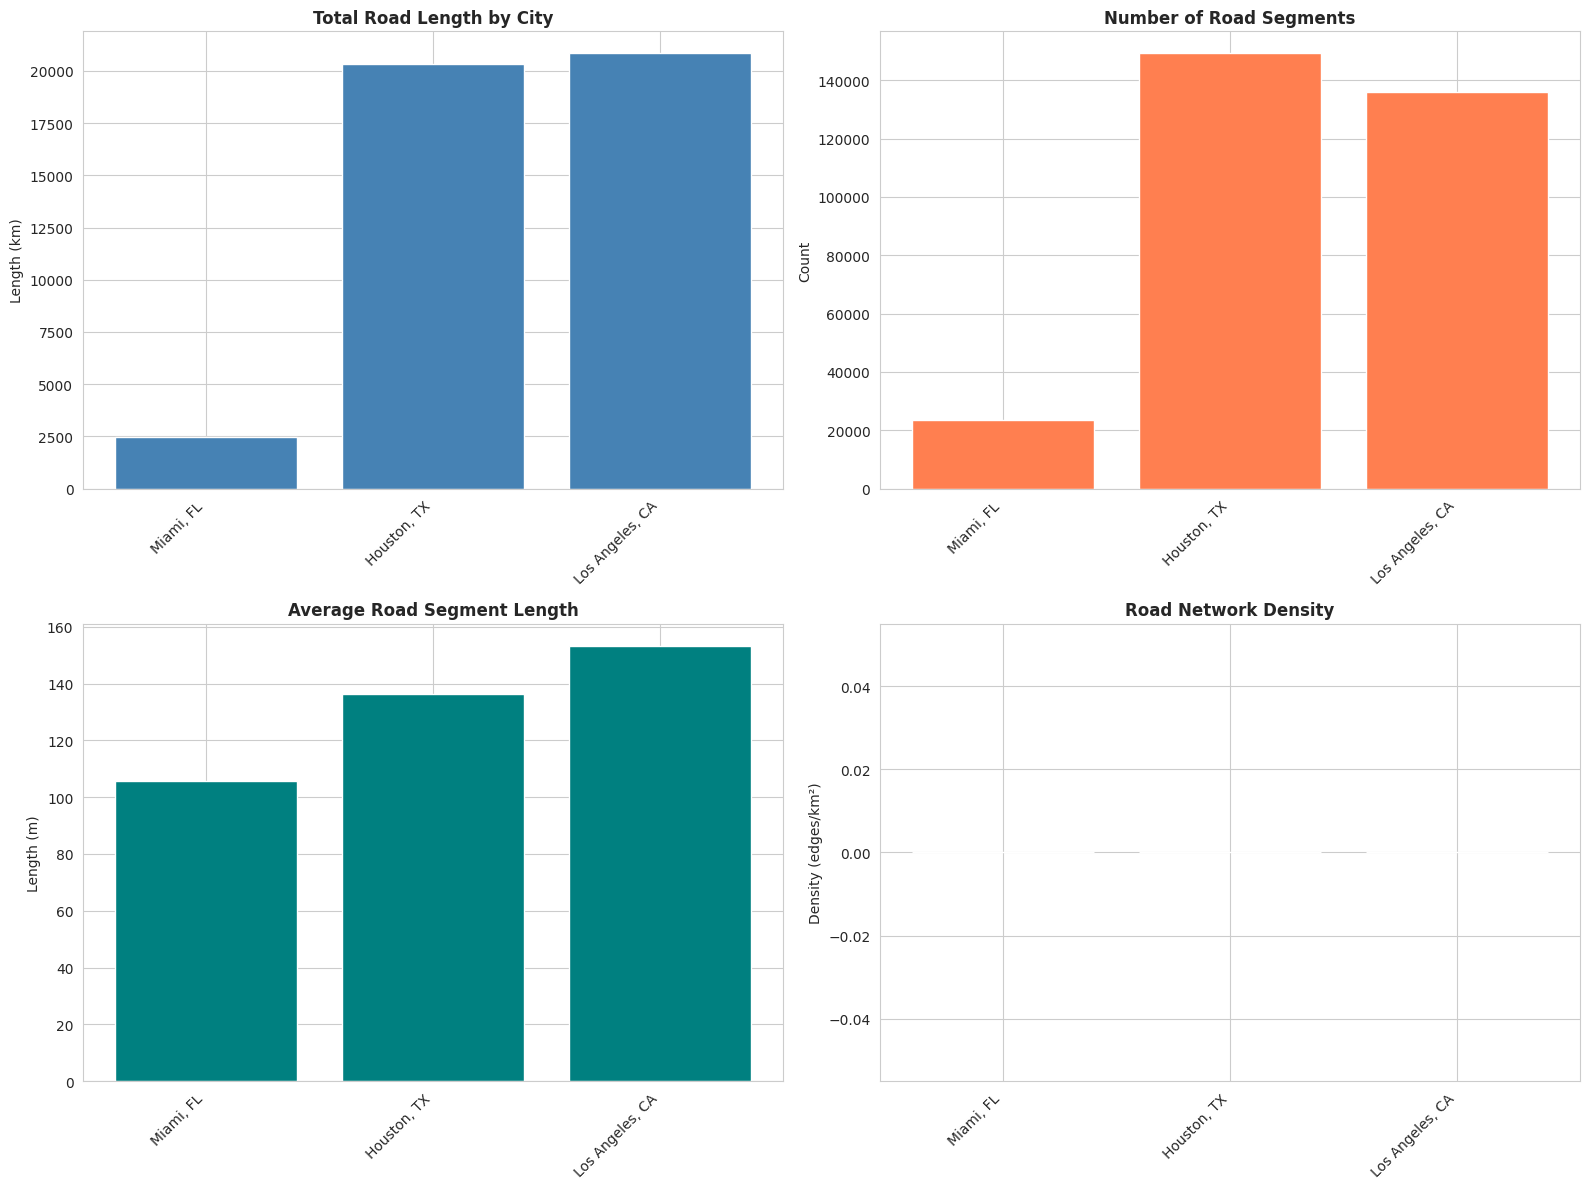

In [30]:
# Visualize network statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total road length
axes[0, 0].bar(range(len(df_network_stats)), df_network_stats['Total_Length_km'], color='steelblue')
axes[0, 0].set_title('Total Road Length by City', fontweight='bold')
axes[0, 0].set_ylabel('Length (km)')
axes[0, 0].set_xticks(range(len(df_network_stats)))
axes[0, 0].set_xticklabels(df_network_stats['Location'], rotation=45, ha='right')

# Number of edges
axes[0, 1].bar(range(len(df_network_stats)), df_network_stats['Edges'], color='coral')
axes[0, 1].set_title('Number of Road Segments', fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(range(len(df_network_stats)))
axes[0, 1].set_xticklabels(df_network_stats['Location'], rotation=45, ha='right')

# Average edge length
axes[1, 0].bar(range(len(df_network_stats)), df_network_stats['Avg_Edge_Length_m'], color='teal')
axes[1, 0].set_title('Average Road Segment Length', fontweight='bold')
axes[1, 0].set_ylabel('Length (m)')
axes[1, 0].set_xticks(range(len(df_network_stats)))
axes[1, 0].set_xticklabels(df_network_stats['Location'], rotation=45, ha='right')

# Network density
axes[1, 1].bar(range(len(df_network_stats)), df_network_stats['Network_Density'], color='purple')
axes[1, 1].set_title('Road Network Density', fontweight='bold')
axes[1, 1].set_ylabel('Density (edges/km²)')
axes[1, 1].set_xticks(range(len(df_network_stats)))
axes[1, 1].set_xticklabels(df_network_stats['Location'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 6. Road Type Distribution

Analyze the distribution of different road types in the downloaded networks.

In [ ]:
# Analyze road types across all networks
all_edges = []

for location, data in road_networks.items():
    edges = data['edges'].copy()
    edges['location'] = location
    all_edges.append(edges)

# Combine all edges
df_all_edges = pd.concat(all_edges, ignore_index=True)

print(f"Total road segments across all networks: {len(df_all_edges):,}")
print("\nAvailable edge attributes:")
print(df_all_edges.columns.tolist())

Total road segments across all networks: 308,783

Available edge attributes:
['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'ref', 'oneway', 'reversed', 'length', 'geometry', 'tunnel', 'bridge', 'junction', 'access', 'location', 'width']


In [37]:
display(df_all_edges.head())

,osmid,highway,lanes,maxspeed,name,ref,oneway,reversed,length,geometry,tunnel,bridge,junction,access,location,width,highway_type
0,190659858,secondary,4,40 mph,Northeast 54th Street,FL 944,False,True,58.886335,"LINESTRING (-80.19474 25.82531, -80.19416 25.8...",NaN,NaN,NaN,NaN,"Miami, FL",NaN,secondary
1,11103222,residential,NaN,NaN,Northeast Miami Place,NaN,False,False,97.471688,"LINESTRING (-80.19474 25.82531, -80.19477 25.8...",NaN,NaN,NaN,NaN,"Miami, FL",NaN,residential
2,"[190659858, 1377712196]",secondary,"[4, 5]",40 mph,Northeast 54th Street,FL 944,False,False,70.711645,"LINESTRING (-80.19474 25.82531, -80.19476 25.8...",NaN,NaN,NaN,NaN,"Miami, FL",NaN,secondary
3,11168721,residential,NaN,NaN,Northeast 55th Street,NaN,False,False,61.994919,"LINESTRING (-80.19479 25.82619, -80.19417 25.8...",NaN,NaN,NaN,NaN,"Miami, FL",NaN,residential
4,11168721,residential,NaN,NaN,Northeast 55th Street,NaN,False,True,71.038233,"LINESTRING (-80.19479 25.82619, -80.1955 25.82...",NaN,NaN,NaN,NaN,"Miami, FL",NaN,residential


Top 15 Road Types:
residential           196,143 (63.52%)
secondary              41,701 (13.50%)
tertiary               34,104 (11.04%)
primary                16,468 ( 5.33%)
secondary_link          6,273 ( 2.03%)
unclassified            5,693 ( 1.84%)
motorway_link           2,647 ( 0.86%)
motorway                2,008 ( 0.65%)
primary_link            1,731 ( 0.56%)
tertiary_link             958 ( 0.31%)
trunk                     514 ( 0.17%)
trunk_link                267 ( 0.09%)
living_street             150 ( 0.05%)
busway                    120 ( 0.04%)
residential_link            4 ( 0.00%)


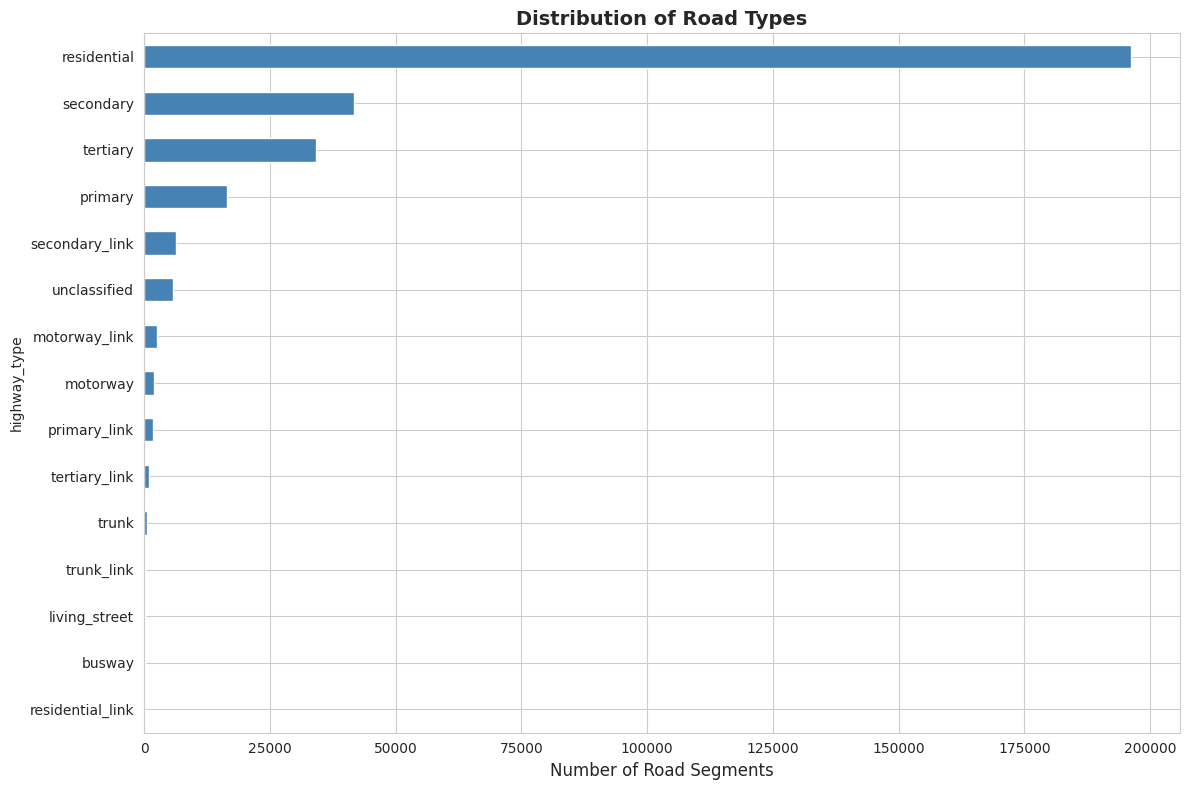

In [32]:
# Analyze 'highway' type distribution (primary road classification in OSM)
if 'highway' in df_all_edges.columns:
    # Handle lists in highway column (some roads have multiple types)
    def extract_primary_highway(x):
        if isinstance(x, list):
            return x[0] if len(x) > 0 else 'unknown'
        return x if pd.notna(x) else 'unknown'
    
    df_all_edges['highway_type'] = df_all_edges['highway'].apply(extract_primary_highway)
    
    highway_counts = df_all_edges['highway_type'].value_counts().head(15)
    
    print("Top 15 Road Types:")
    print("="*60)
    for road_type, count in highway_counts.items():
        pct = (count / len(df_all_edges)) * 100
        print(f"{road_type:20s} {count:>8,} ({pct:5.2f}%)")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 8))
    highway_counts.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Distribution of Road Types', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Road Segments', fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'highway' attribute not found in edge data")

## 7. Road Attributes Analysis

Examine key road attributes that may be relevant for accident analysis.

In [33]:
# Analyze key attributes
attribute_coverage = {}

key_attributes = ['highway', 'name', 'maxspeed', 'lanes', 'oneway', 'surface', 'bridge', 'tunnel']

for attr in key_attributes:
    if attr in df_all_edges.columns:
        non_null = df_all_edges[attr].notna().sum()
        coverage_pct = (non_null / len(df_all_edges)) * 100
        attribute_coverage[attr] = {
            'Available': non_null,
            'Coverage_%': coverage_pct
        }

df_coverage = pd.DataFrame(attribute_coverage).T

print("Road Attribute Coverage:")
print("="*60)
display(df_coverage.round(2))

Road Attribute Coverage:


,Available,Coverage_%
highway,308783.0,100.00
name,291743.0,94.48
maxspeed,66008.0,21.38
lanes,145951.0,47.27
oneway,308783.0,100.00
bridge,4605.0,1.49
tunnel,171.0,0.06


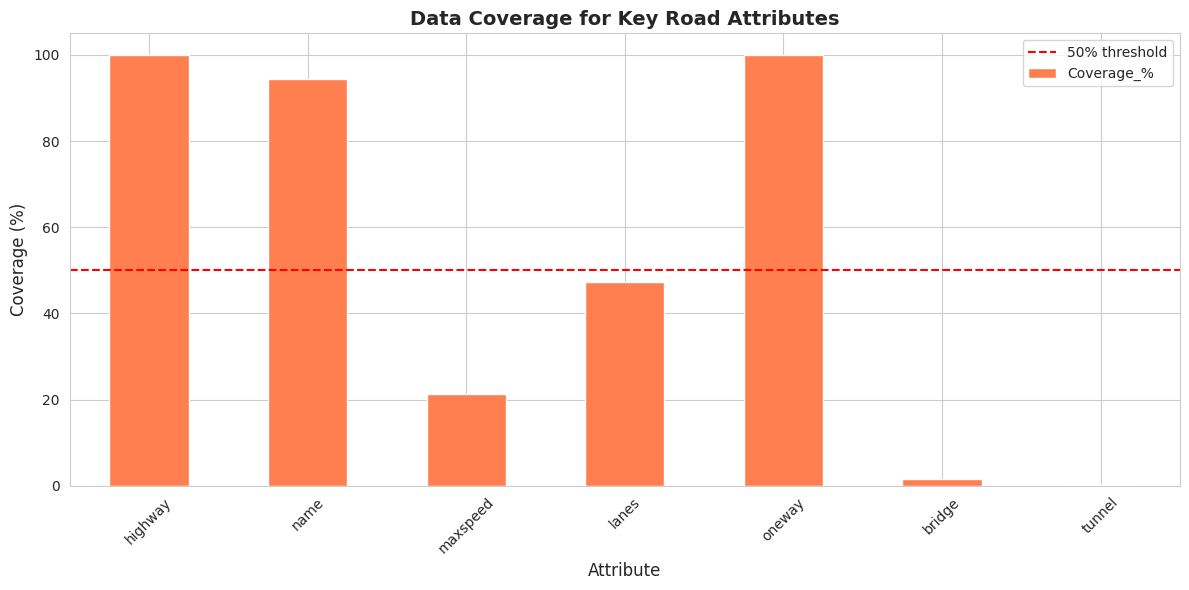

In [34]:
# Visualize attribute coverage
fig, ax = plt.subplots(figsize=(12, 6))
df_coverage['Coverage_%'].plot(kind='bar', ax=ax, color='coral')
ax.set_title('Data Coverage for Key Road Attributes', fontsize=14, fontweight='bold')
ax.set_xlabel('Attribute', fontsize=12)
ax.set_ylabel('Coverage (%)', fontsize=12)
ax.axhline(y=50, color='red', linestyle='--', label='50% threshold')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Analyze numeric attributes
numeric_attrs = ['length', 'lanes']

for attr in numeric_attrs:
    if attr in df_all_edges.columns:
        # Convert to numeric if needed
        if attr == 'lanes':
            def extract_lanes(x):
                if pd.isna(x):
                    return np.nan
                if isinstance(x, list):
                    x = x[0]
                try:
                    return float(x)
                except:
                    return np.nan
            
            df_all_edges['lanes_numeric'] = df_all_edges['lanes'].apply(extract_lanes)
            
            print(f"\nLanes Distribution:")
            print(df_all_edges['lanes_numeric'].describe())
        
        elif attr == 'length':
            print(f"\nLength Statistics (meters):")
            print(df_all_edges['length'].describe())


Length Statistics (meters):
count    308783.000000
mean        141.413427
std         137.843731
min           0.499459
25%          71.349781
50%         101.227264
75%         187.831974
max        6663.331692
Name: length, dtype: float64
count    308783.000000
mean        141.413427
std         137.843731
min           0.499459
25%          71.349781
50%         101.227264
75%         187.831974
max        6663.331692
Name: length, dtype: float64


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 8. Visualize Sample Road Network

Visualize one of the downloaded road networks to inspect the data quality.

Visualizing road network for: Miami, FL


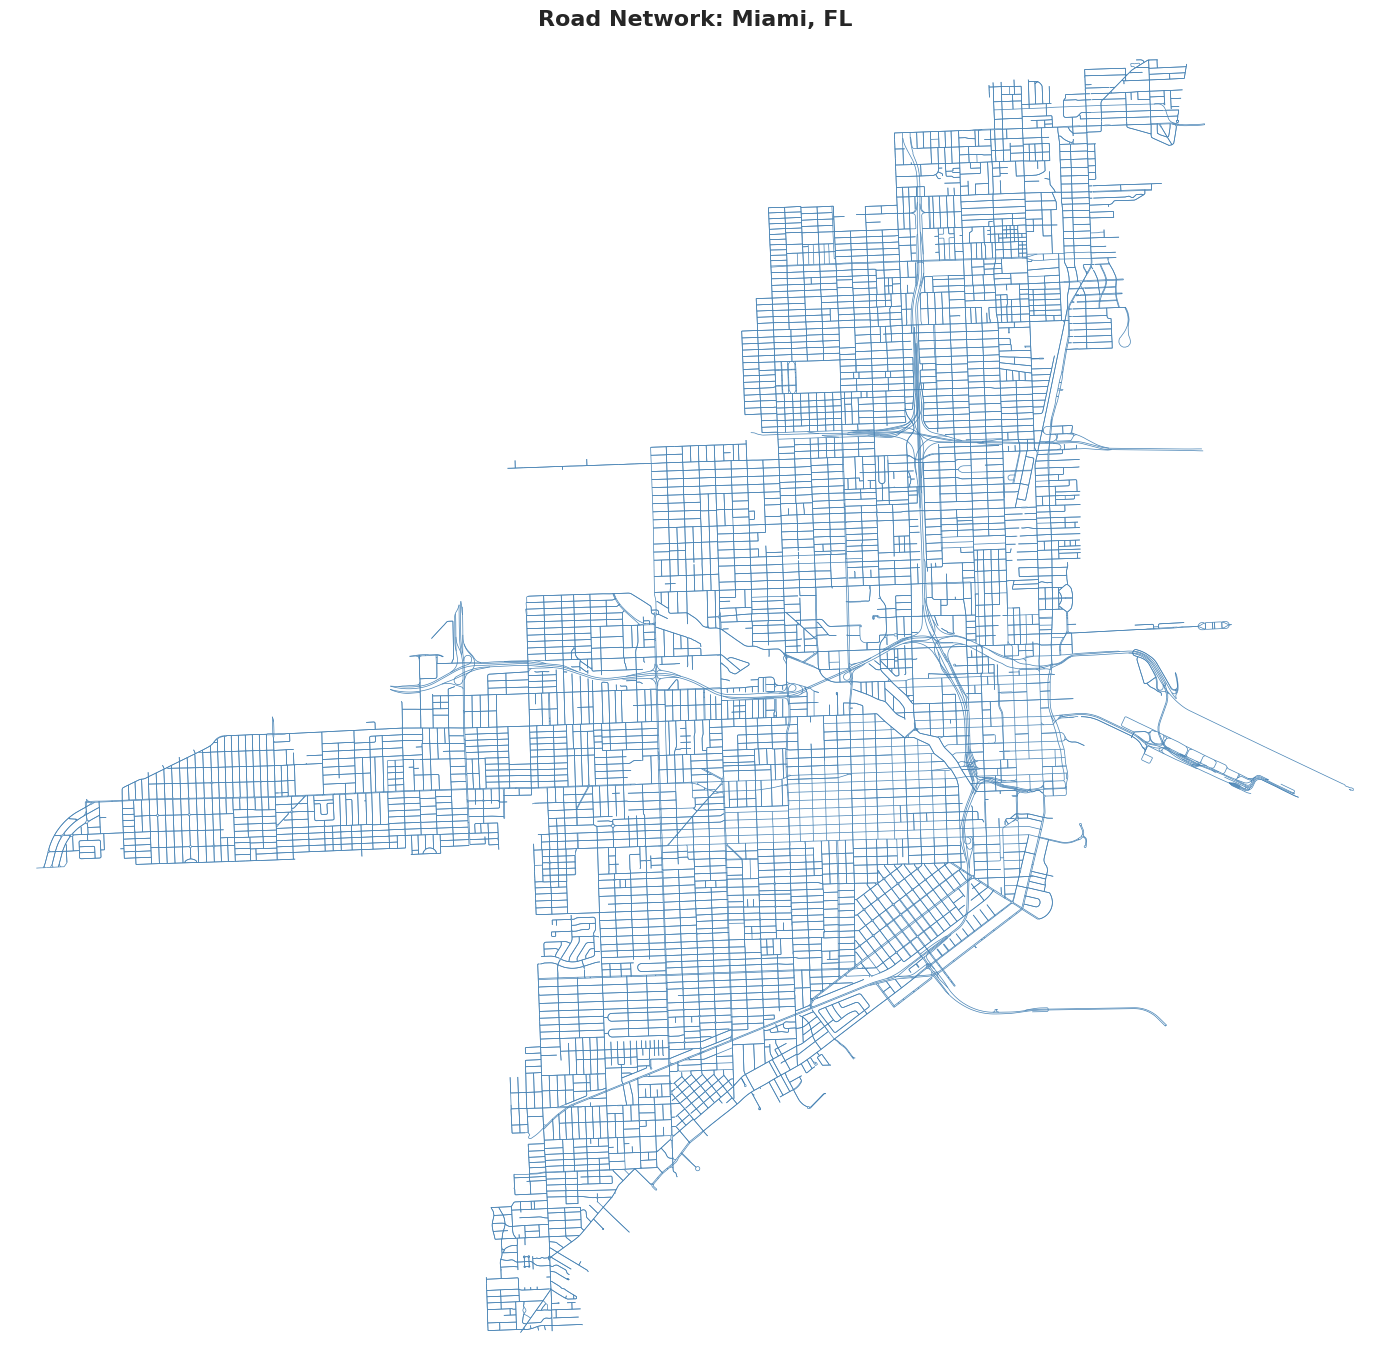

In [38]:
# Visualize the first network
if len(road_networks) > 0:
    first_location = list(road_networks.keys())[0]
    G = road_networks[first_location]['graph']
    
    print(f"Visualizing road network for: {first_location}")
    
    # Plot network
    fig, ax = ox.plot_graph(
        G,
        node_size=0,
        edge_linewidth=0.5,
        edge_color='steelblue',
        bgcolor='white',
        figsize=(14, 14),
        show=False,
        close=False
    )
    
    ax.set_title(f"Road Network: {first_location}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No road networks available for visualization")

## 9. Data Quality Assessment

In [39]:
# Quality checks
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

print(f"\n📊 Network Coverage:")
print(f"   • Cities with road data: {len(road_networks)}")
print(f"   • Total road segments: {len(df_all_edges):,}")
print(f"   • Total road length: {df_all_edges['length'].sum() / 1000:.2f} km")

print(f"\n📍 Geometric Quality:")
print(f"   • Valid geometries: {df_all_edges.geometry.is_valid.sum():,} / {len(df_all_edges):,}")
print(f"   • Mean segment length: {df_all_edges['length'].mean():.2f} m")
print(f"   • Median segment length: {df_all_edges['length'].median():.2f} m")

print(f"\n🏷️ Attribute Completeness:")
for attr, data in attribute_coverage.items():
    print(f"   • {attr:15s}: {data['Coverage_%']:>6.2f}% coverage")

print(f"\n⚠️ Data Quality Issues:")
# Check for extremely short segments
very_short = (df_all_edges['length'] < 1).sum()
print(f"   • Very short segments (<1m): {very_short:,} ({very_short/len(df_all_edges)*100:.2f}%)")

# Check for extremely long segments
very_long = (df_all_edges['length'] > 5000).sum()
print(f"   • Very long segments (>5km): {very_long:,} ({very_long/len(df_all_edges)*100:.2f}%)")

print("\n" + "="*80)

DATA QUALITY ASSESSMENT

📊 Network Coverage:
   • Cities with road data: 3
   • Total road segments: 308,783
   • Total road length: 43666.06 km

📍 Geometric Quality:
   • Valid geometries: 308,783 / 308,783
   • Mean segment length: 141.41 m
   • Median segment length: 101.23 m

🏷️ Attribute Completeness:
   • highway        : 100.00% coverage
   • name           :  94.48% coverage
   • maxspeed       :  21.38% coverage
   • lanes          :  47.27% coverage
   • oneway         : 100.00% coverage
   • bridge         :   1.49% coverage
   • tunnel         :   0.06% coverage

⚠️ Data Quality Issues:
   • Very short segments (<1m): 49 (0.02%)
   • Very long segments (>5km): 6 (0.00%)



## 10. Save Processed Road Networks

Save the downloaded road networks for use in spatial joining with accident data.

In [40]:
# Create directory for OSM data if it doesn't exist
osm_data_dir = Config.DATA_DIR / "osm_networks"
osm_data_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving road networks to: {osm_data_dir}")
print("="*60)

# Save each network separately
for location, data in road_networks.items():
    # Create safe filename
    safe_name = location.replace(", ", "_").replace(" ", "_")
    
    # Save edges as GeoPackage (better than shapefile for attributes)
    edges_path = osm_data_dir / f"{safe_name}_edges.gpkg"
    data['edges'].to_file(edges_path, driver='GPKG')
    print(f"✓ Saved: {edges_path.name}")
    
    # Save nodes
    nodes_path = osm_data_dir / f"{safe_name}_nodes.gpkg"
    data['nodes'].to_file(nodes_path, driver='GPKG')
    print(f"✓ Saved: {nodes_path.name}")

# Save combined edges dataset
combined_edges_path = osm_data_dir / "all_edges_combined.gpkg"
df_all_edges.to_file(combined_edges_path, driver='GPKG')
print(f"\n✓ Saved combined dataset: {combined_edges_path.name}")

# Save network statistics
stats_path = osm_data_dir / "network_statistics.csv"
df_network_stats.to_csv(stats_path, index=False)
print(f"✓ Saved statistics: {stats_path.name}")

print("\n" + "="*60)
print("✓ All road network data saved successfully!")

Saving road networks to: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/osm_networks
✓ Saved: Miami_FL_edges.gpkg
✓ Saved: Miami_FL_nodes.gpkg
✓ Saved: Miami_FL_edges.gpkg
✓ Saved: Miami_FL_nodes.gpkg
✓ Saved: Houston_TX_edges.gpkg
✓ Saved: Houston_TX_edges.gpkg
✓ Saved: Houston_TX_nodes.gpkg
✓ Saved: Houston_TX_nodes.gpkg
✓ Saved: Los_Angeles_CA_edges.gpkg
✓ Saved: Los_Angeles_CA_edges.gpkg
✓ Saved: Los_Angeles_CA_nodes.gpkg
✓ Saved: Los_Angeles_CA_nodes.gpkg

✓ Saved combined dataset: all_edges_combined.gpkg
✓ Saved statistics: network_statistics.csv

✓ All road network data saved successfully!

✓ Saved combined dataset: all_edges_combined.gpkg
✓ Saved statistics: network_statistics.csv

✓ All road network data saved successfully!


## Summary and Next Steps

### Key Findings:
- Downloaded road networks for top accident-prone cities
- Analyzed road types, attributes, and network structure
- Assessed data quality and attribute coverage
- Saved processed networks for spatial analysis

### Next Steps:
1. **Notebook 03**: Perform spatial join between accidents and road segments
   - Match each accident to nearest road segment
   - Transfer road attributes to accident records
   - Validate spatial matching quality

2. **Notebook 04**: Clean and preprocess integrated dataset
   - Handle missing values
   - Feature engineering
   - Final dataset preparation for modeling

---

**OSM road network data loaded and processed! ✓**